# Testing kmeans method with image windows

## Loading the image 

In [13]:
import commonmethods.image_modification as im

image = im.load_image_grayscale('5')

resized_image = im.resize_image(image, 1024)

## Method for getting the image windows

In [70]:
import numpy as np

def get_window(image, row_number, column_number, px):
    """
    Method for getting the px x px sized window from the image.
    :param image: the image that I want to get the window from
    :param row_number: the row where the window left corner pixel should start
    :param column_number: the column where the window left corner pixel should start
    :param px: the width and height of the window
    :return: the px x px sized window from the image
    """
    window = np.zeros((px, px))

    for i in range(0, px):
        column = np.zeros((px))
        for j in range(0, px):
            column[j] = image[row_number+i][column_number+j]
        window[i] = column
    
    return window

## Testing the above method and plotting the window

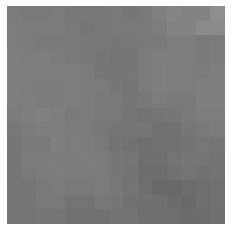

In [14]:
from matplotlib import pyplot as plt

px = 15

result_window = get_window(resized_image, 720, 780, px)

plt.axis("off")

plt.imshow(result_window, cmap="gray", vmin=0, vmax=255)

## Tetsing the kmeans to different windows

In [5]:
import cv2
import commonmethods.image_modification as im

px = 15

window1 = get_window(resized_image, 658, 557, px)
window1 = window1.reshape((1, -1))
window2 = get_window(resized_image, 354, 610, px)
window2 = window2.reshape((1, -1))

values = np.vstack((window1,window2,window1, window2, window2, window1))

_, labels, _ = im.kmeans_segmentation(values, 2)

print(labels)

[0 1 0 1 1 0]


In [6]:
import cv2

px = 15

window_avokado1 = get_window(resized_image, 658, 557, px)
window_avokado2 = get_window(resized_image, 595, 600, px)
window_background = get_window(resized_image, 354, 610, px)
window_vase1 = get_window(resized_image, 600, 360, px)
window_vase2 = get_window(resized_image, 700, 320, px)
window_paprika = get_window(resized_image, 720, 780, px)

window_avokado1 = window_avokado1.reshape((1, -1))
window_avokado2 = window_avokado2.reshape((1, -1))
window_background = window_background.reshape((1, -1))
window_vase1 = window_vase1.reshape((1, -1))
window_vase2 = window_vase2.reshape((1, -1))
window_paprika = window_paprika.reshape((1, -1))

values = np.vstack((window_avokado1, window_avokado2, window_background, window_vase1, window_vase2, window_paprika))

_, labels, _ = im.kmeans_segmentation(values, 4)

print(labels)

[3 3 2 1 1 0]


## Getting the optimal cluster size

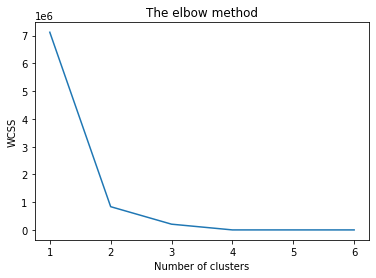

In [76]:
import commonmethods.image_modification as im

wcss = []   #within cluster sum of squares

for k in range(1, len(values)+1):
    compactness, _, _ = im.kmeans_segmentation(values, k)
    wcss.append(compactness)

plt.plot(range(1, len(values)+1), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [77]:
import commonmethods.image_modification as im
import commonmethods.optimal_cluster_number as ocn

#the best value and the cluster which resulted
s_closest = [0, 2]
db_min = [1000000, 2]
ch_max = [0, 2]

for i in range(2, len(values)):
        
    _, labels, _ = im.kmeans_segmentation(values, i)
    
    print(labels)

    s_time, s_score = ocn.silhouette_method(values, labels)
    db_time, db_score = ocn.davies_bouldin_method(values, labels)
    ch_time, ch_score = ocn.calinski_harabasz_method(values, labels)
    
    print("k: {}, S: {}, DB: {}, CH: {}".format(i, s_score, db_score, ch_score))
    
    #get the best cluster number for each methods
    if((1-s_score) < (1-s_closest[0])):
        s_closest = [s_score, i]

    if(db_score < db_min[0]):
        db_min = [db_score, i]

    if(ch_score > ch_max[0]):
        ch_max = [ch_score, i]
        
print(s_closest)
print(db_min)
print(ch_max)

[1 1 0 1 1 0]
k: 2, S: 0.7336547546204378, DB: 0.30638383651044465, CH: 30.02712212100285
[2 0 1 2 2 1]
k: 3, S: 0.6805395847659831, DB: 0.18710482880159307, CH: 50.19768510864788
[2 1 0 2 2 3]
k: 4, S: 0.49412054451904414, DB: 0.005003797301654004, CH: 32823.657450076804
[1 3 0 4 4 2]
k: 5, S: 0.25731329329715097, DB: 0.04655615733519185, CH: 323766.9469696969
[0.7336547546204378, 2]
[0.005003797301654004, 4]
[323766.9469696969, 5]


## Get windows

In [15]:
import numpy as np

def get_window_values(image, window_quantity, px):
    """
    Method for getting random windows from the image, stacked in one vector. 
    The resulted vector size will be window_quantity x px*px.
    :param image: the image that i want to get the random windows from
    :param window_quantity: the amount of windows that i want to get
    :param px: the width and height of the windows
    :return: the result, which is the vector created from the 1 x px*px sized windows, 
        and the pixels, an array that contains the start pixels of the windows
    """
    height = image.shape[0]
    width = image.shape[1]
    
    pixels = np.zeros((window_quantity, 2))
    
    #get random window start pixels
    x = np.random.randint(0, height-px, window_quantity)
    y = np.random.randint(0, width-px, window_quantity)
    
    for i in range(window_quantity):
        window = get_window(image, x[i], y[i], px)
        window = window.reshape((1, -1))
        pixels[i] = [x[i], y[i]] #saving the start pixels of the windows
        
        if i == 0:
            result = np.array(window)
        else:
            result = np.vstack([result, window])
    
    return result, pixels

In [115]:
import cv2
import numpy as np

def color_image(image, label_map):
    """
    Method for colorizing the image based on the label_map. 
    :param image: the image which I want to colorize
    :param label_map: the map of the labels, I choose the color of the pixels 
        by the label given to the pixel
    :return: the colorized image
    """
    height = image.shape[0]
    width = image.shape[1]
    
    colored_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    colors = np.array([
        [0, 0, 255],   #blue
        [255, 0, 0],   #red
        [255, 255, 0], #yellow
        [0, 255, 0],   #lime
        [0, 255, 255], #cyan
        [255, 150, 0]  #orange
    ])

    for i in range(height):
        for j in range(width):
            if(label_map[i][j] != -1):
                colored_image[i][j] = colors[label_map[i][j]]
                
    return colored_image

In [113]:
def get_label_map(height, width, pixels, labels, px):
    """
    Method for getting the label to each pixel of the windows. 
    :param height: the height of the image that contains the windows
    :param width: the width of the image that contains the windows
    :param pixels: the starting pixels of the previously 
        calculated windows
    :param px: the width and height of the windows
    :return: an array in the shape of the image, 
        the values are -1 where the pixel is not segmented, 
        the labels elswhere
    """
    label_map = np.full((height, width), -1)

    for i in range(len(pixels)):
        for j in range(0, px):
            for k in range(0, px):
                label_map[int(pixels[i][0]+j)][int(pixels[i][1]+k)] =\
                    labels[i]
                
    return label_map

In [87]:
def segment_and_color_image(image, values, k, pixels, px):
    """
    Method for segmenting the windows and colorizing the image with them.
    :param image: the image which I want to segment and colorize
    :param values: the values at which I want to perform segmentation
    :param k: the number of the clusters
    :param pixels: the starting pixels of the previously calculated windows
    :param px: the width and height of the windows
    :return: the segmented and colorized image
    """
    _,labels,_ = im.kmeans_segmentation(values, k)
    
    label_map = get_label_map(image.shape[0], image.shape[1], pixels, labels, px)

    return color_image(image, label_map)

## Kmeans segmentation by texture (feature vector)

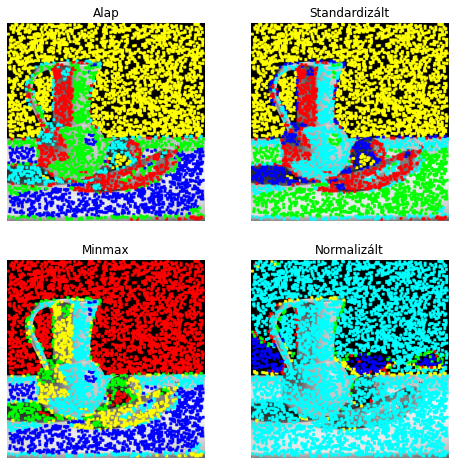

In [83]:
import cv2
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

px = 15
k = 5

image = im.load_image_grayscale('5')

resized_image = im.resize_image(image, 1024)

window_values, pixels = get_window_values(resized_image, 5000, px)

colored_base_image = segment_and_color_image(resized_image, window_values, k, pixels, px)

fig = plt.figure(figsize=(8,8))

image1 = fig.add_subplot(2,2,1)
image1.axis("off")
image1.set_title("Alap")
image1.imshow(colored_base_image, cmap="gray", vmin=0, vmax=255)

scale = StandardScaler()
scaled_data = scale.fit_transform(window_values)

colored_standard_image = segment_and_color_image(resized_image, scaled_data, k, pixels, px)

image2 = fig.add_subplot(2,2,2)
image2.axis("off")
image2.set_title("Standardizált")
image2.imshow(colored_standard_image, cmap="gray", vmin=0, vmax=255)
 
min_max_scaler = MinMaxScaler()
minmax = min_max_scaler.fit_transform(window_values)

colored_minmax_image = segment_and_color_image(resized_image, minmax, k, pixels, px)

image3 = fig.add_subplot(2,2,3)
image3.axis("off")
image3.set_title("Minmax")
image3.imshow(colored_minmax_image, cmap="gray", vmin=0, vmax=255)

normalized = normalize(window_values, norm='l2')

colored_normalize_image = segment_and_color_image(resized_image, normalized, k, pixels, px)

image4 = fig.add_subplot(2,2,4)
image4.axis("off")
image4.set_title("Normalizált")
image4.imshow(colored_normalize_image, cmap="gray", vmin=0, vmax=255)

## KNN classaification (feature vector)

In [52]:
from sklearn.neighbors import KNeighborsClassifier
import commonmethods.image_modification as im
import math
from sklearn.model_selection import train_test_split

px = 15

window_values, pixels = get_window_values(resized_image, 1000, px)

k = 5
_, labels, _ = im.kmeans_segmentation(window_values, k)

values_train, values_test, labels_train, labels_test = train_test_split(window_values, labels, stratify = labels, train_size = 0.8)

neighbors = int(math.sqrt(window_values.shape[0]))

knn_model = KNeighborsClassifier(n_neighbors=neighbors)

knn_model.fit(values_train, labels_train)

labels_pred = knn_model.predict(values_test)

print('Train accuracy: {}'.format(knn_model.score(values_train, labels_train)))
print('Test accuracy: {}'.format(knn_model.score(values_test, labels_test)))

Train accuracy: 0.97875
Test accuracy: 0.98


[3]


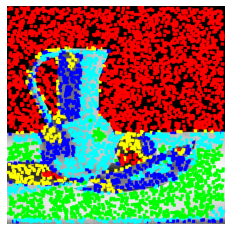

In [116]:
from sklearn.neighbors import KNeighborsClassifier
import commonmethods.image_modification as im
import math
from sklearn.model_selection import train_test_split

px = 15

window_values, pixels = get_window_values(resized_image, 5000, px)

k = 5
_, labels, _ = im.kmeans_segmentation(window_values, k)

colored_image = segment_and_color_image(resized_image, window_values, k, pixels, px)

plt.axis("off")

plt.imshow(colored_image)

neighbors = int(math.sqrt(window_values.shape[0]))

knn_model = KNeighborsClassifier(n_neighbors=neighbors)

knn_model.fit(window_values, labels)

test_window = get_window(resized_image, 300, 300, px)

test_window = test_window.reshape((1, -1))

predicted= knn_model.predict(test_window)
print(predicted)

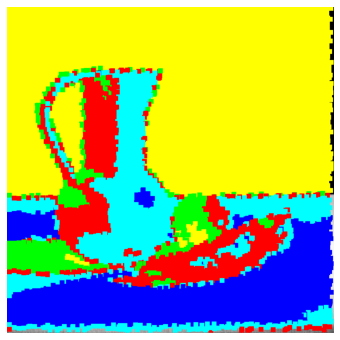

In [88]:
from sklearn.neighbors import KNeighborsClassifier
import commonmethods.image_modification as im
import math
from sklearn.model_selection import train_test_split
import cv2

px = 15
image = im.load_image_grayscale('5')
resized_image = im.resize_image(image, 1024)

height = resized_image.shape[0]
width = resized_image.shape[1]

window_values, pixels = get_window_values(resized_image, 1000, px)

k = 5
_, labels, _ = im.kmeans_segmentation(window_values, k)

neighbors = int(math.sqrt(window_values.shape[0]))

knn_model = KNeighborsClassifier(n_neighbors=neighbors)
knn_model.fit(window_values, labels)

label_map = get_label_map(height, width, pixels, labels, px)

for i in range(height-px):
    for j in range(width-px):
        if(label_map[i][j] == -1):
            test_window = get_window(resized_image, i, j, px)

            test_window = test_window.reshape((1, -1))

            predicted = knn_model.predict(test_window)
            
            for k in range(0, px):
                for l in range(0, px):
                    label_map[i+k][j+l] = predicted

colored_image = color_image(resized_image, label_map)

plt.figure(figsize=(6,6))

plt.axis("off")

plt.imshow(colored_image)

## KNN classification (all pixels)

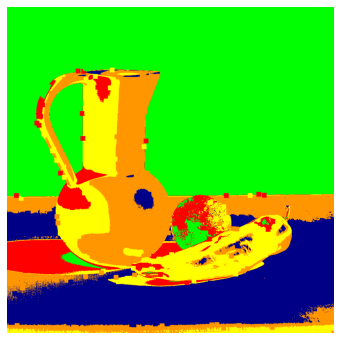

In [69]:
from sklearn.neighbors import KNeighborsClassifier
import commonmethods.image_modification as im
import math

px = 15

image = im.load_image_grayscale('5')
resized_image = im.resize_image(image, 1024)

height = resized_image.shape[0]
width = resized_image.shape[1]

window_values, pixels = get_window_values(resized_image, 1000, px)
_, labels, _ = im.kmeans_segmentation(window_values, 5)

window_values = window_values.reshape((-1, 1))

label_map = np.full((height, width), -1)
train_labels = []

for i in range(len(pixels)):
    for j in range(0, px):
        for k in range(0, px):
            label_map[int(pixels[i][0]+j)][int(pixels[i][1]+k)] = labels[i]
            train_labels.append(labels[i])

neighbors = int(math.sqrt(window_values.shape[0]))
knn_model = KNeighborsClassifier(n_neighbors=neighbors)
knn_model.fit(window_values, train_labels)
            
for i in range(height):
    for j in range(width):
        if(label_map[i][j] == -1):
            test_pixel = resized_image[i][j]
            test_pixel = test_pixel.reshape((1, -1))

            predicted = knn_model.predict(test_pixel)
            
            label_map[i][j] = predicted

colored_image = color_image(resized_image, label_map)

plt.figure(figsize=(6,6))

plt.axis("off")

plt.imshow(colored_image)